In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pyarrow as pa
import pyarrow.parquet as pq

nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jaredsulzdorf/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaredsulzdorf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/jaredsulzdorf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jaredsulzdorf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# read sotu.jsonl into a DataFrame and output the head
sotu = pd.read_json("data/sotu.jsonl", lines=True)
sotu.head()

,potus,date,categories,speech_html
0,Joseph R. Biden,2021-04-28,"[Presidential, Spoken Addresses and Remarks, t...",Thank you. Thank you. Thank you. Good to be b...
1,Richard Nixon,1972-01-20,"[Presidential, Spoken Addresses and Remarks, S...","Mr. Speaker, Mr. President, my colleagues in t..."
2,Lyndon B. Johnson,1966-01-12,"[Presidential, Spoken Addresses and Remarks, S...",[ Delivered in person before a joint session a...
3,Lyndon B. Johnson,1965-01-04,"[Presidential, Spoken Addresses and Remarks, S...","On this Hill which was my home, I am stirred b..."
4,Richard Nixon,1972-01-20,"[Presidential, Messages, State of the Union Wr...",To the Congress of the United States: It was j...


In [5]:
# count the unique number of potus in the DataFrame to make sure we have the correct number
sotu["potus"].nunique()

43

In [6]:
# print out the unique values of potus, sorted alphabetically
sotu[sotu["potus"].isna()]

,potus,date,categories,speech_html
8,None,NaT,[],


In [7]:
# drop the nas
sotu = sotu.dropna(subset=["potus"])
sotu.isna().sum()

potus          0
date           0
categories     0
speech_html    0
dtype: int64

In [8]:
# print out the data types of the columns
sotu.dtypes

potus                  object
date           datetime64[ns]
categories             object
speech_html            object
dtype: object

In [9]:
# print out the categories
sotu["categories"].value_counts()

categories
[Presidential, Messages, State of the Union Written Messages, to the Congress]                              140
[Presidential, Spoken Addresses and Remarks, State of the Union Addresses, to the Congress]                  69
[Presidential, Spoken Addresses and Remarks, State of the Union Addresses, to the Congress, Watch Video]     31
[Presidential, Spoken Addresses and Remarks, State of the Union Written Messages]                             5
[Presidential, Spoken Addresses and Remarks, to the Congress]                                                 4
[Presidential, Spoken Addresses and Remarks, to the Congress, Watch Video]                                    3
[Presidential, Spoken Addresses and Remarks, Major to the Nation]                                             2
[Presidential, Messages, to the Congress]                                                                     1
Name: count, dtype: int64

In [10]:
# drop any row that doesn't inlclude "State of the Union Addresses" or "State of the Union Written Messages" in the categories array
sotu = sotu[
    sotu["categories"].apply(
        lambda x: "State of the Union Addresses" in x
        or "State of the Union Written Messages" in x
    )
]
sotu["categories"].value_counts()

categories
[Presidential, Messages, State of the Union Written Messages, to the Congress]                              140
[Presidential, Spoken Addresses and Remarks, State of the Union Addresses, to the Congress]                  69
[Presidential, Spoken Addresses and Remarks, State of the Union Addresses, to the Congress, Watch Video]     31
[Presidential, Spoken Addresses and Remarks, State of the Union Written Messages]                             5
Name: count, dtype: int64

In [11]:
# If the "categories" column contains "Spoken Addresses and Remarks", set the "type" column to "spoken"
sotu.loc[
    sotu["categories"].apply(lambda x: "Spoken Addresses and Remarks" in x),
    "categories",
] = "Spoken"
sotu.loc[
    sotu["categories"].apply(lambda x: "State of the Union Written Messages" in x),
    "categories",
] = "Written"
sotu["categories"].value_counts()

categories
Written    140
Spoken     105
Name: count, dtype: int64

In [12]:
import contractions

sotu["no-contractions"] = sotu["speech_html"].apply(
    lambda x: " ".join([contractions.fix(word) for word in x.split()])
)
sotu.head()

,potus,date,categories,speech_html,no-contractions
1,Richard Nixon,1972-01-20,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t..."
2,Lyndon B. Johnson,1966-01-12,Spoken,[ Delivered in person before a joint session a...,[ Delivered in person before a joint session a...
3,Lyndon B. Johnson,1965-01-04,Spoken,"On this Hill which was my home, I am stirred b...","On this Hill which was my home, I am stirred b..."
4,Richard Nixon,1972-01-20,Written,To the Congress of the United States: It was j...,To the Congress of the United States: It was j...
5,Richard Nixon,1970-01-22,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t..."


In [13]:
# Tokenize the no-contractions column
sotu["tokens"] = sotu["no-contractions"].apply(word_tokenize)
# from the tokens column, remove punctuation, keep numbers
sotu["tokens"] = sotu["tokens"].apply(
    lambda x: [word for word in x if word.isalnum() or word.isdigit()]
)
# lowercase the token column
sotu["tokens"] = sotu["tokens"].apply(lambda x: [word.lower() for word in x])
sotu.head()

,potus,date,categories,speech_html,no-contractions,tokens
1,Richard Nixon,1972-01-20,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ..."
2,Lyndon B. Johnson,1966-01-12,Spoken,[ Delivered in person before a joint session a...,[ Delivered in person before a joint session a...,"[delivered, in, person, before, a, joint, sess..."
3,Lyndon B. Johnson,1965-01-04,Spoken,"On this Hill which was my home, I am stirred b...","On this Hill which was my home, I am stirred b...","[on, this, hill, which, was, my, home, i, am, ..."
4,Richard Nixon,1972-01-20,Written,To the Congress of the United States: It was j...,To the Congress of the United States: It was j...,"[to, the, congress, of, the, united, states, i..."
5,Richard Nixon,1970-01-22,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ..."


In [14]:
stop_words = set(stopwords.words("english"))
sotu["tokens-nostop"] = sotu["tokens"].apply(
    lambda x: [word for word in x if word not in stop_words]
)
sotu.head()

,potus,date,categories,speech_html,no-contractions,tokens,tokens-nostop
1,Richard Nixon,1972-01-20,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis..."
2,Lyndon B. Johnson,1966-01-12,Spoken,[ Delivered in person before a joint session a...,[ Delivered in person before a joint session a...,"[delivered, in, person, before, a, joint, sess...","[delivered, person, joint, session, speaker, p..."
3,Lyndon B. Johnson,1965-01-04,Spoken,"On this Hill which was my home, I am stirred b...","On this Hill which was my home, I am stirred b...","[on, this, hill, which, was, my, home, i, am, ...","[hill, home, stirred, old, friendships, though..."
4,Richard Nixon,1972-01-20,Written,To the Congress of the United States: It was j...,To the Congress of the United States: It was j...,"[to, the, congress, of, the, united, states, i...","[congress, united, states, 3, years, ago, toda..."
5,Richard Nixon,1970-01-22,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis..."


In [15]:
sotu["lemmatized"] = sotu["tokens-nostop"].apply(nltk.tag.pos_tag)
sotu.head()

,potus,date,categories,speech_html,no-contractions,tokens,tokens-nostop,lemmatized
1,Richard Nixon,1972-01-20,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[(speaker, NN), (president, NN), (colleagues, ..."
2,Lyndon B. Johnson,1966-01-12,Spoken,[ Delivered in person before a joint session a...,[ Delivered in person before a joint session a...,"[delivered, in, person, before, a, joint, sess...","[delivered, person, joint, session, speaker, p...","[(delivered, VBN), (person, NN), (joint, NN), ..."
3,Lyndon B. Johnson,1965-01-04,Spoken,"On this Hill which was my home, I am stirred b...","On this Hill which was my home, I am stirred b...","[on, this, hill, which, was, my, home, i, am, ...","[hill, home, stirred, old, friendships, though...","[(hill, NN), (home, NN), (stirred, VBD), (old,..."
4,Richard Nixon,1972-01-20,Written,To the Congress of the United States: It was j...,To the Congress of the United States: It was j...,"[to, the, congress, of, the, united, states, i...","[congress, united, states, 3, years, ago, toda...","[(congress, NN), (united, VBD), (states, NNS),..."
5,Richard Nixon,1970-01-22,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[(speaker, NN), (president, NN), (colleagues, ..."


In [16]:
def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


sotu["lemmatized"] = sotu["lemmatized"].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x]
)
sotu.head()

,potus,date,categories,speech_html,no-contractions,tokens,tokens-nostop,lemmatized
1,Richard Nixon,1972-01-20,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[(speaker, n), (president, n), (colleagues, n)..."
2,Lyndon B. Johnson,1966-01-12,Spoken,[ Delivered in person before a joint session a...,[ Delivered in person before a joint session a...,"[delivered, in, person, before, a, joint, sess...","[delivered, person, joint, session, speaker, p...","[(delivered, v), (person, n), (joint, n), (ses..."
3,Lyndon B. Johnson,1965-01-04,Spoken,"On this Hill which was my home, I am stirred b...","On this Hill which was my home, I am stirred b...","[on, this, hill, which, was, my, home, i, am, ...","[hill, home, stirred, old, friendships, though...","[(hill, n), (home, n), (stirred, v), (old, a),..."
4,Richard Nixon,1972-01-20,Written,To the Congress of the United States: It was j...,To the Congress of the United States: It was j...,"[to, the, congress, of, the, united, states, i...","[congress, united, states, 3, years, ago, toda...","[(congress, n), (united, v), (states, n), (3, ..."
5,Richard Nixon,1970-01-22,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[(speaker, n), (president, n), (colleagues, n)..."


In [17]:
wnl = WordNetLemmatizer()
sotu["lemmatized"] = sotu["lemmatized"].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x]
)
sotu.head()

,potus,date,categories,speech_html,no-contractions,tokens,tokens-nostop,lemmatized
1,Richard Nixon,1972-01-20,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[speaker, president, colleague, congress, dist..."
2,Lyndon B. Johnson,1966-01-12,Spoken,[ Delivered in person before a joint session a...,[ Delivered in person before a joint session a...,"[delivered, in, person, before, a, joint, sess...","[delivered, person, joint, session, speaker, p...","[deliver, person, joint, session, speaker, pre..."
3,Lyndon B. Johnson,1965-01-04,Spoken,"On this Hill which was my home, I am stirred b...","On this Hill which was my home, I am stirred b...","[on, this, hill, which, was, my, home, i, am, ...","[hill, home, stirred, old, friendships, though...","[hill, home, stir, old, friendship, though, to..."
4,Richard Nixon,1972-01-20,Written,To the Congress of the United States: It was j...,To the Congress of the United States: It was j...,"[to, the, congress, of, the, united, states, i...","[congress, united, states, 3, years, ago, toda...","[congress, unite, state, 3, year, ago, today, ..."
5,Richard Nixon,1970-01-22,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[speaker, president, colleague, congress, dist..."


In [18]:
# Save to a Parquet file
parquet_table = pa.Table.from_pandas(sotu)
pq.write_table(parquet_table, "sotu.parquet")

In [19]:
sotu_parquet = pd.read_parquet("sotu.parquet")
sotu_parquet.head()

,potus,date,categories,speech_html,no-contractions,tokens,tokens-nostop,lemmatized
1,Richard Nixon,1972-01-20,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[speaker, president, colleague, congress, dist..."
2,Lyndon B. Johnson,1966-01-12,Spoken,[ Delivered in person before a joint session a...,[ Delivered in person before a joint session a...,"[delivered, in, person, before, a, joint, sess...","[delivered, person, joint, session, speaker, p...","[deliver, person, joint, session, speaker, pre..."
3,Lyndon B. Johnson,1965-01-04,Spoken,"On this Hill which was my home, I am stirred b...","On this Hill which was my home, I am stirred b...","[on, this, hill, which, was, my, home, i, am, ...","[hill, home, stirred, old, friendships, though...","[hill, home, stir, old, friendship, though, to..."
4,Richard Nixon,1972-01-20,Written,To the Congress of the United States: It was j...,To the Congress of the United States: It was j...,"[to, the, congress, of, the, united, states, i...","[congress, united, states, 3, years, ago, toda...","[congress, unite, state, 3, year, ago, today, ..."
5,Richard Nixon,1970-01-22,Spoken,"Mr. Speaker, Mr. President, my colleagues in t...","Mr. Speaker, Mr. President, my colleagues in t...","[speaker, president, my, colleagues, in, the, ...","[speaker, president, colleagues, congress, dis...","[speaker, president, colleague, congress, dist..."


<Axes: >

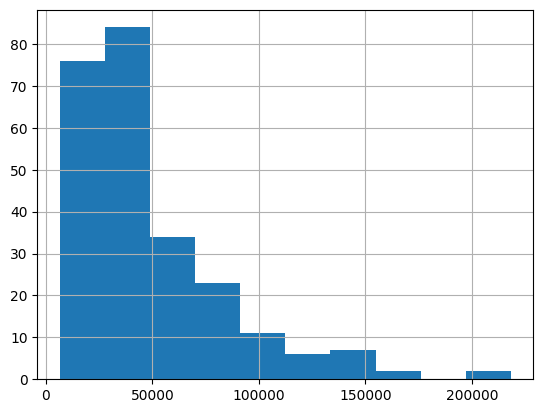

In [88]:
sotu["speech_html"].str.len().hist()

<Axes: >

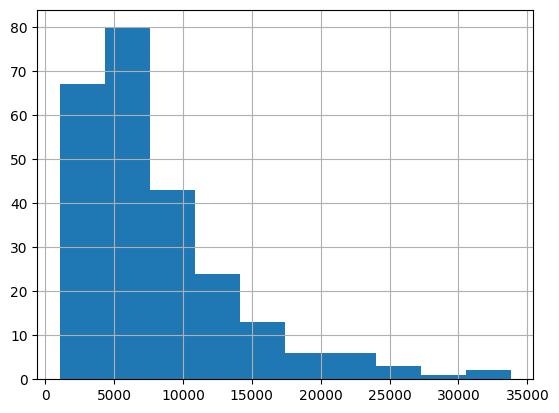

In [89]:
sotu["speech_html"].str.split().apply(len).hist()

In [95]:
# Create a new column called "word_count" that contains the number of words in the "speech_html" column
sotu["word_count"] = sotu["speech_html"].apply(lambda x: len(x.split()))
# then list the top 5 rows of the DataFrame sorted by word_count
sotu.sort_values("word_count", ascending=False).head(100)

,potus,date,categories,speech_html,no-contractions,tokens,tokens-nostop,lemmatized,word_count
13,Jimmy Carter,1981-01-16,Written,To the Congress of the United States: The Stat...,To the Congress of the United States: The Stat...,"[to, the, congress, of, the, united, states, t...","[congress, united, states, state, union, sound...","[congress, united, state, state, union, sound,...",33797
14,Jimmy Carter,1980-01-21,Written,To the Congress of the United States: My State...,To the Congress of the United States: My State...,"[to, the, congress, of, the, united, states, m...","[congress, united, states, state, union, addre...","[congress, united, state, state, union, addres...",33426
144,Theodore Roosevelt,1907-12-03,Written,"No nation has greater resources than ours, and...","No nation has greater resources than ours, and...","[no, nation, has, greater, resources, than, ou...","[nation, greater, resources, think, truthfully...","[nation, great, resource, think, truthfully, s...",27371
149,William Howard Taft,1910-12-06,Written,During the past year the foreign relations of ...,During the past year the foreign relations of ...,"[during, the, past, year, the, foreign, relati...","[past, year, foreign, relations, united, state...","[past, year, foreign, relation, united, state,...",26869
146,Theodore Roosevelt,1905-12-05,Written,The people of this country continue to enjoy g...,The people of this country continue to enjoy g...,"[the, people, of, this, country, continue, to,...","[people, country, continue, enjoy, great, pros...","[people, country, continue, enjoy, great, pros...",25026
...,...,...,...,...,...,...,...,...,...
152,Woodrow Wilson,1915-12-07,Spoken,Since I last had the privilege of addressing y...,Since I last had the privilege of addressing y...,"[since, i, last, had, the, privilege, of, addr...","[since, last, privilege, addressing, state, un...","[since, last, privilege, address, state, union...",7681
106,Ulysses S. Grant,1869-12-06,Written,In coming before you for the first time as Chi...,In coming before you for the first time as Chi...,"[in, coming, before, you, for, the, first, tim...","[coming, first, time, chief, magistrate, great...","[come, first, time, chief, magistrate, great, ...",7680
255,Joseph R. Biden,2022-03-01,Spoken,"Thank you all very, very much. Thank you, ple...","Thank you all very, very much. Thank you, plea...","[thank, you, all, very, very, much, thank, you...","[thank, much, thank, please, thank, much, mada...","[thank, much, thank, please, thank, much, mada...",7636
87,Zachary Taylor,1849-12-04,Written,Sixty years have elapsed since the establishme...,Sixty years have elapsed since the establishme...,"[sixty, years, have, elapsed, since, the, esta...","[sixty, years, elapsed, since, establishment, ...","[sixty, year, elapse, since, establishment, go...",7609


In [99]:
# split the DataFrame into two DataFrames, one for spoken and one for written
spoken = sotu[sotu["categories"] == "Spoken"]
written = sotu[sotu["categories"] == "Written"]
# print the shape of each dataframe
print(spoken.shape, written.shape)
# print the average number of words in each dataframe
print(written["word_count"].mean(), spoken["word_count"].mean())
# create a column for average word length in the speech_html column
# plot the most common words from the tokens-nostop column
# show the top trigrams from the speech_html column
# plot the length of the speeches over time
# who are the top 5 presidents by shortest and longest speeches?
# who are the top 5 presidents by shortest and longest word length
# Does the type of speech influcnec the length of the speech and the average word length?

(105, 9) (140, 9)
10552.471428571429 4720.628571428571


<Axes: >

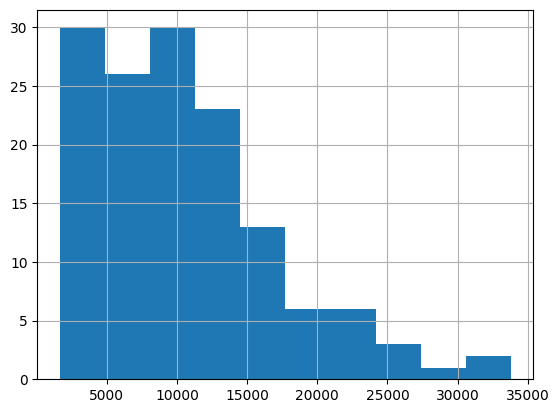

In [101]:
written["speech_html"].str.split().apply(len).hist()

<Axes: >

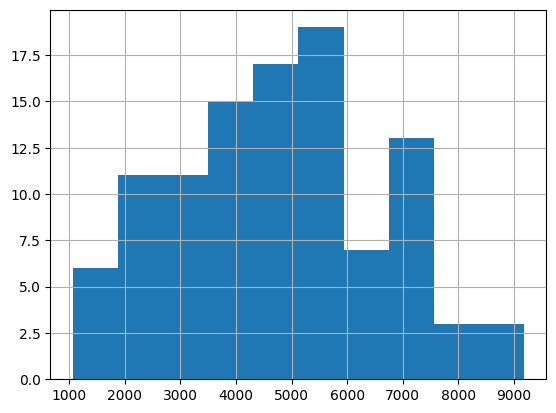

In [102]:
spoken["speech_html"].str.split().apply(len).hist()

In [103]:
# compute the average number of words for each speech grouped by potus
written.groupby("potus")["word_count"].mean().sort_values(ascending=False)

potus
Jimmy Carter             25202.750
William Howard Taft      22169.000
Theodore Roosevelt       19573.750
William McKinley         18556.500
James K. Polk            17995.000
James Buchanan           14082.000
Grover Cleveland         13934.000
Benjamin Harrison        13610.500
Martin van Buren         11317.500
Andrew Jackson           11181.000
Rutherford B. Hayes      10817.750
Millard Fillmore         10485.000
Franklin Pierce          10440.500
Chester A. Arthur         9878.000
Harry S Truman            9607.000
Andrew Johnson            9529.250
Calvin Coolidge           8930.000
Ulysses S. Grant          8914.375
John Tyler                8484.000
Richard Nixon             8292.500
John Quincy Adams         7646.750
Zachary Taylor            7609.000
Dwight D. Eisenhower      7227.500
Abraham Lincoln           6809.000
Herbert Hoover            6358.750
Franklin D. Roosevelt     5964.000
James Monroe              5195.500
Woodrow Wilson            3730.500
James Madison 

<Axes: xlabel='date'>

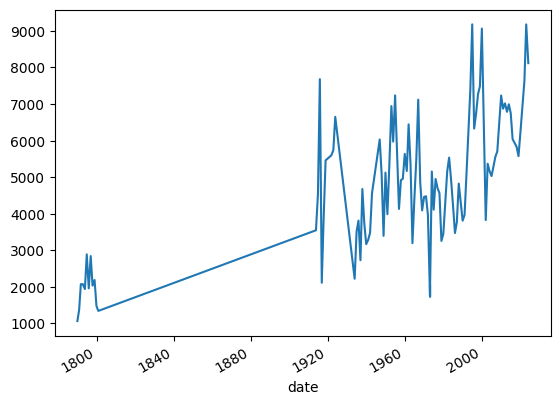

In [125]:
# plot the word_count column by date for spoken speeches
spoken.groupby("date")["word_count"].mean().plot()

<BarContainer object of 20 artists>

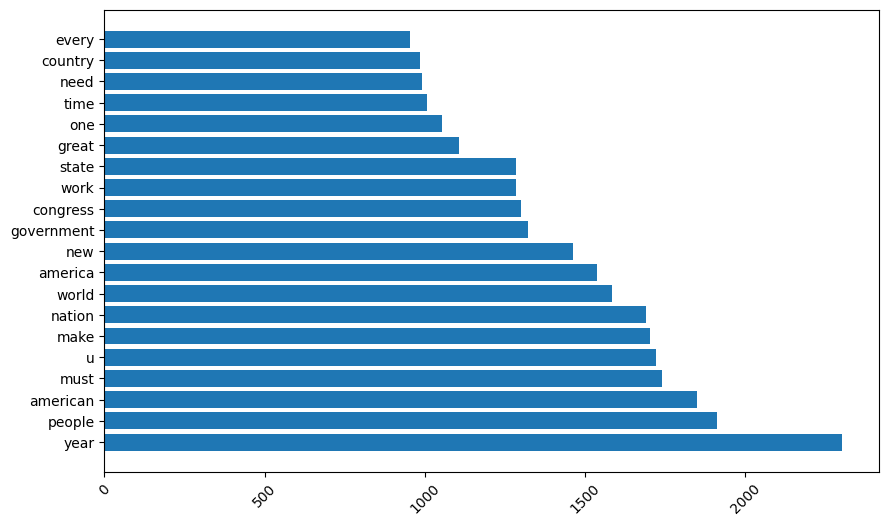

In [138]:
# plot the most common words from the tokens-nostop column
from collections import Counter

common_words = spoken["lemmatized"].apply(Counter).sum().most_common(20)
# unzip the list of tuples and plot the words and counts as a bar chart
words, counts = zip(*common_words)
# create a figure
plt.figure(figsize=(10, 6))
# tilt the x-axis labels
plt.xticks(rotation=45)
# make the bar chart horizontal in decreasing order
plt.barh(words, counts)

[(('state', 'local', 'governments'), 11), (('five', 'years', 'ago'), 7), (('president', 'united', 'states'), 5), (('let', 'us', 'see'), 5), (('local', 'law', 'enforcement'), 5), (('past', '5', 'years'), 5), (('thank', 'good', 'afternoon'), 5), (('4', 'years', 'ago'), 5), (('progress', 'toward', 'goal'), 4), (('six', 'great', 'goals'), 4), (('people', 'united', 'states'), 4), (('world', 'war', 'ii'), 4), (('present', 'welfare', 'system'), 4), (('full', 'employment', 'budget'), 4), (('let', 'us', 'share'), 4), (('state', 'union', 'report'), 4), (('speaker', 'president', 'colleagues'), 3), (('president', 'colleagues', 'congress'), 3), (('colleagues', 'congress', 'distinguished'), 3), (('congress', 'distinguished', 'guests'), 3)]


<BarContainer object of 20 artists>

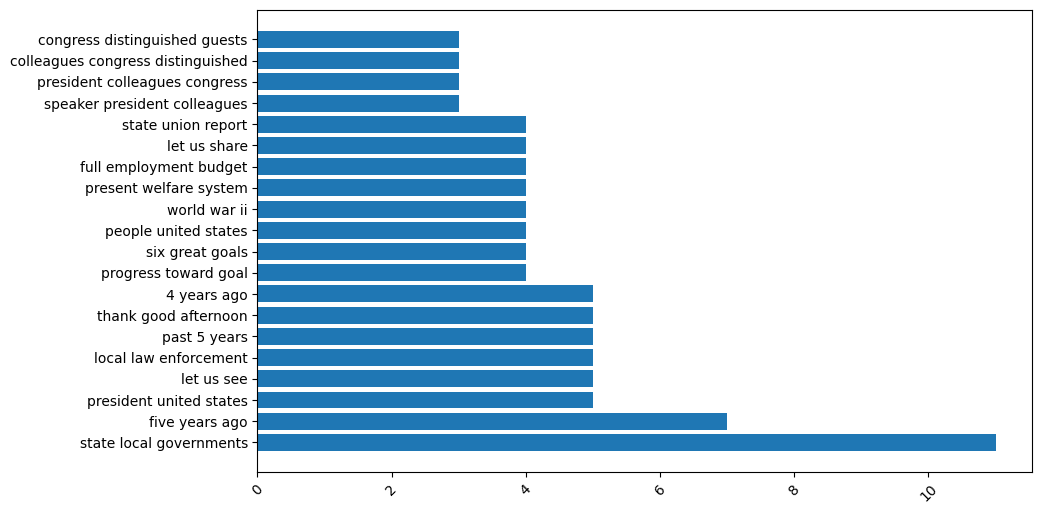

In [155]:
# compute the top trigrams from the speech_html column
from nltk.util import ngrams

# create a Counter object from the trigrams
barak = spoken[spoken["potus"] == "Richard Nixon"]
trigrams = (
    barak["tokens-nostop"].apply(lambda x: list(ngrams(x, 3))).apply(Counter).sum()
)
# get the most common trigrams
common_trigrams = trigrams.most_common(20)
print(common_trigrams)
# unzip the list of tuples and plot the trigrams and counts as a bar chart
trigrams, counts = zip(*common_trigrams)
# join the trigrams into a single string
trigrams = [" ".join(trigram) for trigram in trigrams]
# create a figure
plt.figure(figsize=(10, 6))
# tilt the x-axis labels
plt.xticks(rotation=45)
# make the bar chart horizontal in decreasing order
plt.barh(trigrams, counts)